In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

## Data preparation

In [2]:
data = pd.read_csv("../data/unemployment/data.csv")

In [3]:
data.head()

,Series id,Year,Period,Value
0,LNS14000000,1948,M01,3.4
1,LNS14000000,1948,M02,3.8
2,LNS14000000,1948,M03,4.0
3,LNS14000000,1948,M04,3.9
4,LNS14000000,1948,M05,3.5


In [4]:
data.columns

Index(['Series id', 'Year', 'Period', 'Value'], dtype='object')

In [5]:
data.drop(["Series id"], axis=1, inplace=True)

In [6]:
data["month"] = [int(month[1:]) for month in data.Period]

In [7]:
data.index = pd.date_range('1/1/1948', periods=data.shape[0], freq='MS')

Create datasets with missing data

In [8]:
sample_idx = np.random.choice(data.index, data.shape[0], replace=True)

In [9]:
missing_data = data["Value"].copy()
missing_data.loc[sample_idx] = None

with higher probability of missing high values

In [10]:
sample_idx2 = np.random.choice(data.index, data.shape[0], replace=True, p=data.Value/sum(data.Value))

In [11]:
missing_data_2 = data["Value"].copy()
missing_data_2.loc[sample_idx2] = None

## Imputation

### Forward Fill

One of the simplest way is to fill in missing values by the last kown value.

In [12]:
ffill_data = missing_data.fillna(method="ffill")
ffill_data.index = pd.date_range('1/1/1948', periods=ffill_data.shape[0], freq='MS')

In [13]:
ffill_data_2 = missing_data_2.fillna(method="ffill")
ffill_data_2.index = pd.date_range('1/1/1948', periods=ffill_data.shape[0], freq='MS')

In [14]:
ts = pd.concat([ffill_data, ffill_data_2, data["Value"]], axis=1)

In [15]:
ts.columns = ["ffill", "ffill_2","original"]

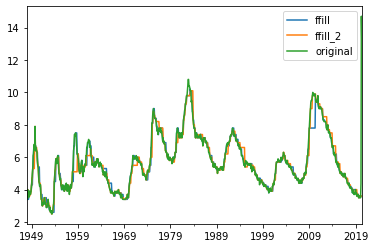

In [16]:
ts.plot()

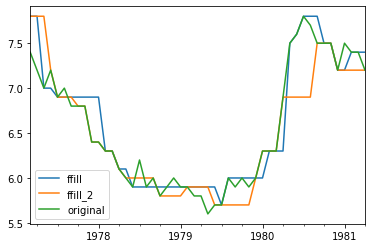

In [17]:
ts.iloc[350:400,:].plot()

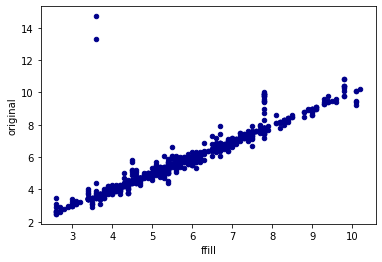

In [18]:
ax1 = ts.plot.scatter(x="ffill",
                      y="original",
                      c='DarkBlue')

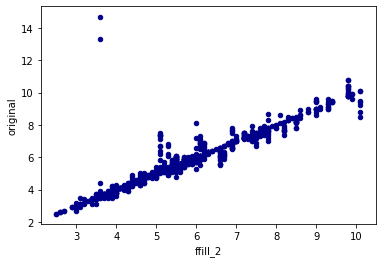

In [19]:
ax1 = ts.plot.scatter(x="ffill_2",
                      y="original",
                      c='DarkBlue')

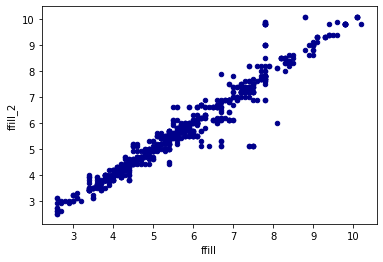

In [20]:
ax1 = ts.plot.scatter(x="ffill",
                      y="ffill_2",
                      c='DarkBlue')

### Moving average

In [21]:
rm_data = missing_data.fillna(missing_data.rolling(6, min_periods=1).mean())
rm_data.index = pd.date_range('1/1/1948', periods=missing_data.shape[0], freq='MS')

rm_data_2 = missing_data_2.fillna(missing_data_2.rolling(6, min_periods=1).mean())
rm_data_2.index = pd.date_range('1/1/1948', periods=missing_data_2.shape[0], freq='MS')

In [22]:
ts = pd.concat([ffill_data, rm_data, rm_data_2, data["Value"]], axis=1)

In [23]:
ts.columns = ["ffill", "rolling", "rolling_2", "original"]

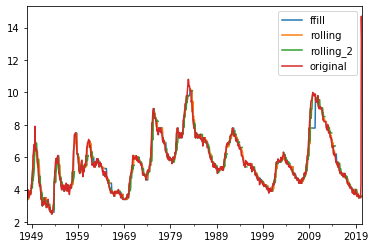

In [24]:
ts.plot()

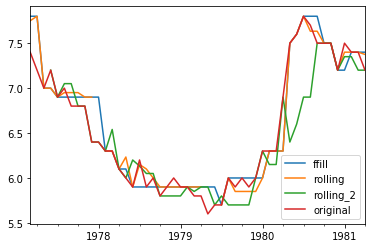

In [25]:
ts.iloc[350:400,:].plot()

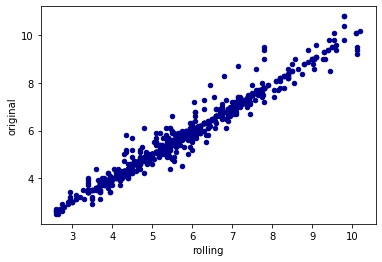

In [26]:
ax1 = ts.plot.scatter(x="rolling",
                      y="original",
                      c='DarkBlue')

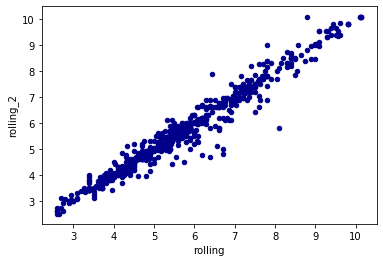

In [27]:
ax1 = ts.plot.scatter(x="rolling",
                      y="rolling_2",
                      c='DarkBlue')

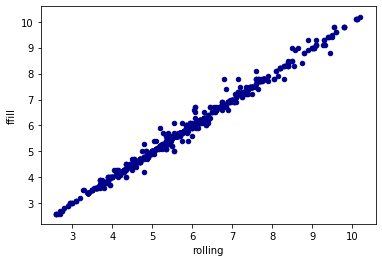

In [28]:
ax1 = ts.plot.scatter(x="rolling",
                      y="ffill",
                      c='DarkBlue')

### Interpolation

In [29]:
linear_interpolation = missing_data.interpolate(method='linear')
linear_interpolation.index = pd.date_range('1/1/1948', periods=linear_interpolation.shape[0], freq='MS')

linear_interpolation_2 = missing_data_2.interpolate(method='linear')
linear_interpolation_2.index = pd.date_range('1/1/1948', periods=linear_interpolation_2.shape[0], freq='MS')

In [30]:
ts = pd.concat([linear_interpolation, linear_interpolation_2, ffill_data, data["Value"]], axis=1)

In [31]:
ts.columns = ["linear", "linear_2", "ffill", "original"]

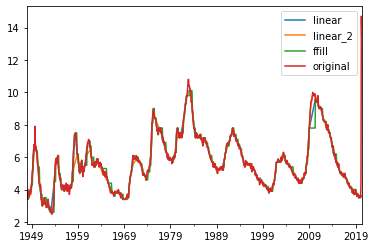

In [32]:
ts.plot()

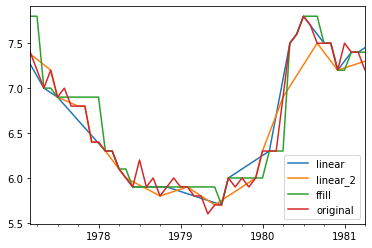

In [33]:
ts.iloc[350:400,:].plot()

### polynomial

In [34]:
polynomial_interpolation = missing_data.interpolate(method='polynomial', order=3)
polynomial_interpolation.index = pd.date_range('1/1/1948', periods=polynomial_interpolation.shape[0], freq='MS')

polynomial_interpolation_2 = missing_data_2.interpolate(method='polynomial', order=3)
polynomial_interpolation_2.index = pd.date_range('1/1/1948', periods=polynomial_interpolation_2.shape[0], freq='MS')

In [35]:
ts = pd.concat([polynomial_interpolation, polynomial_interpolation_2, ffill_data, data["Value"]], axis=1)

In [36]:
ts.columns = ["polynomial", "polynomial_2", "ffill", "original"]

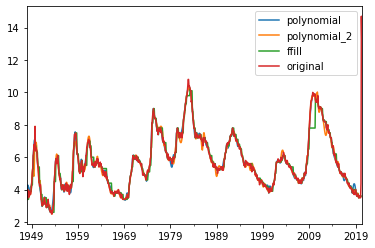

In [37]:
ts.plot()

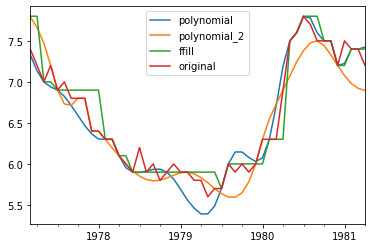

In [38]:
ts.iloc[350:400,:].plot()

In [39]:
def rsme(arr_1, arr_2):
    return np.sqrt(np.sum(np.power(arr_1 - arr_2,2))/len(arr_1))

In [40]:
methods = [[ffill_data, "ffill_data"], 
           [ffill_data_2, "ffill_data_2"], 
           [rm_data, "rm_data"], 
           [rm_data_2, "rm_data_2"],
           [linear_interpolation, "linear_interpolation"], 
           [linear_interpolation_2, "linear_interpolation_2"], 
           [polynomial_interpolation, "polynomial_interpolation"], 
           [polynomial_interpolation_2, "polynomial_interpolation_2"]]

In [41]:
for method in methods:
    error = rsme(method[0], data["Value"])
    print(f"{method[1]}: with {error:.2f}")

ffill_data: with 0.60
ffill_data_2: with 0.61
rm_data: with 0.28
rm_data_2: with 0.60
linear_interpolation: with 0.54
linear_interpolation_2: with 0.54
polynomial_interpolation: with 0.15
polynomial_interpolation_2: with 0.20


Based on our example, the linear interpolation shows the smalles rsme. Both for random imputation and also for impution, whihc affects higher values a bit more.

Other methods like up- or downsampling. For this kind of imputatin, you change the rate of the time series data. This could be like downsampling to a value every 2 month or upsampling to bimonthly values. This is an option, if the original resolution of the data is not sensible. But this is in this example not the case.

### Smoothing Data

Smoothin can help with data preparation, feature generation, prediction (simplest way of prediction), visualization.

In [42]:
air = pd.read_csv("../data/AirPassengers.csv")

In [43]:
air

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [44]:
air["smooth_5"] = air["Passengers"].ewm(alpha=.5).mean()
air["smooth_9"] = air["Passengers"].ewm(alpha=.9).mean()

In [45]:
air.head()

,Month,Passengers,smooth_5,smooth_9
0,1949-01,112,112.000000,112.000000
1,1949-02,118,116.000000,117.454545
2,1949-03,132,125.142857,130.558559
3,1949-04,129,127.200000,129.155716
4,1949-05,121,124.000000,121.815498


Other options for smoothing are Kalman filters or LOESS regression

### Seasonal data

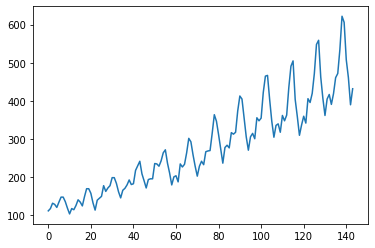

In [46]:
air["Passengers"].plot()

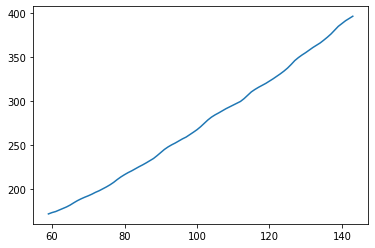

In [47]:
# first test, informally, plot the moving average
# note the ROLLING function
air["Passengers"].rolling(window = 60).mean().plot()

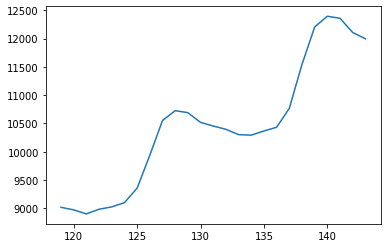

In [48]:
air["Passengers"].rolling(window = 120).var().plot()

In [49]:
from statsmodels.tsa.stattools import adfuller
adfuller(air["Passengers"], autolag = 'AIC', regression = 'ct')

(-2.100781813844673,
 0.5456589343124534,
 13,
 130,
 {'1%': -4.030152423759672,
  '5%': -3.444817634956759,
  '10%': -3.1471816659080565},
 993.2814778200581)

In [50]:
decomp_air = pd.Series(data=air["Passengers"].values, index = pd.date_range('1/1/1949', periods=air.shape[0], freq='MS'))

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(decomp_air, model='additive')

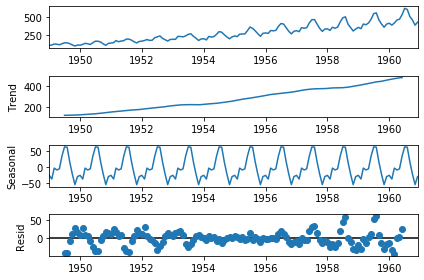

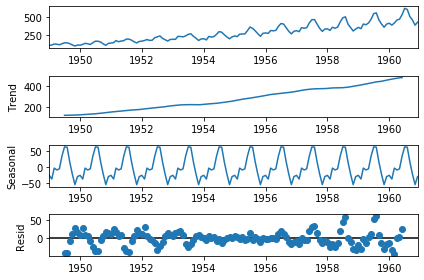

In [52]:
result.plot()